<a href="https://colab.research.google.com/github/fyp-doc-ai/notebooks/blob/main/Char_level_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
!sudo apt install tesseract-ocr-eng
!pip install -q pytesseract
!sudo apt-get install tesseract-ocr-sin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (9,706 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/

In [ ]:
!pip install roboflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 753.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.

# Configs

In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd =  r'/usr/bin/tesseract'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Open image

In [ ]:
import cv2
import re
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
img_path = '/content/drive/MyDrive/FYP19-DocAI/Resources/Filled Forms/Kavishka/Images/CamScanner 08-29-2023 15.39_1.jpg'

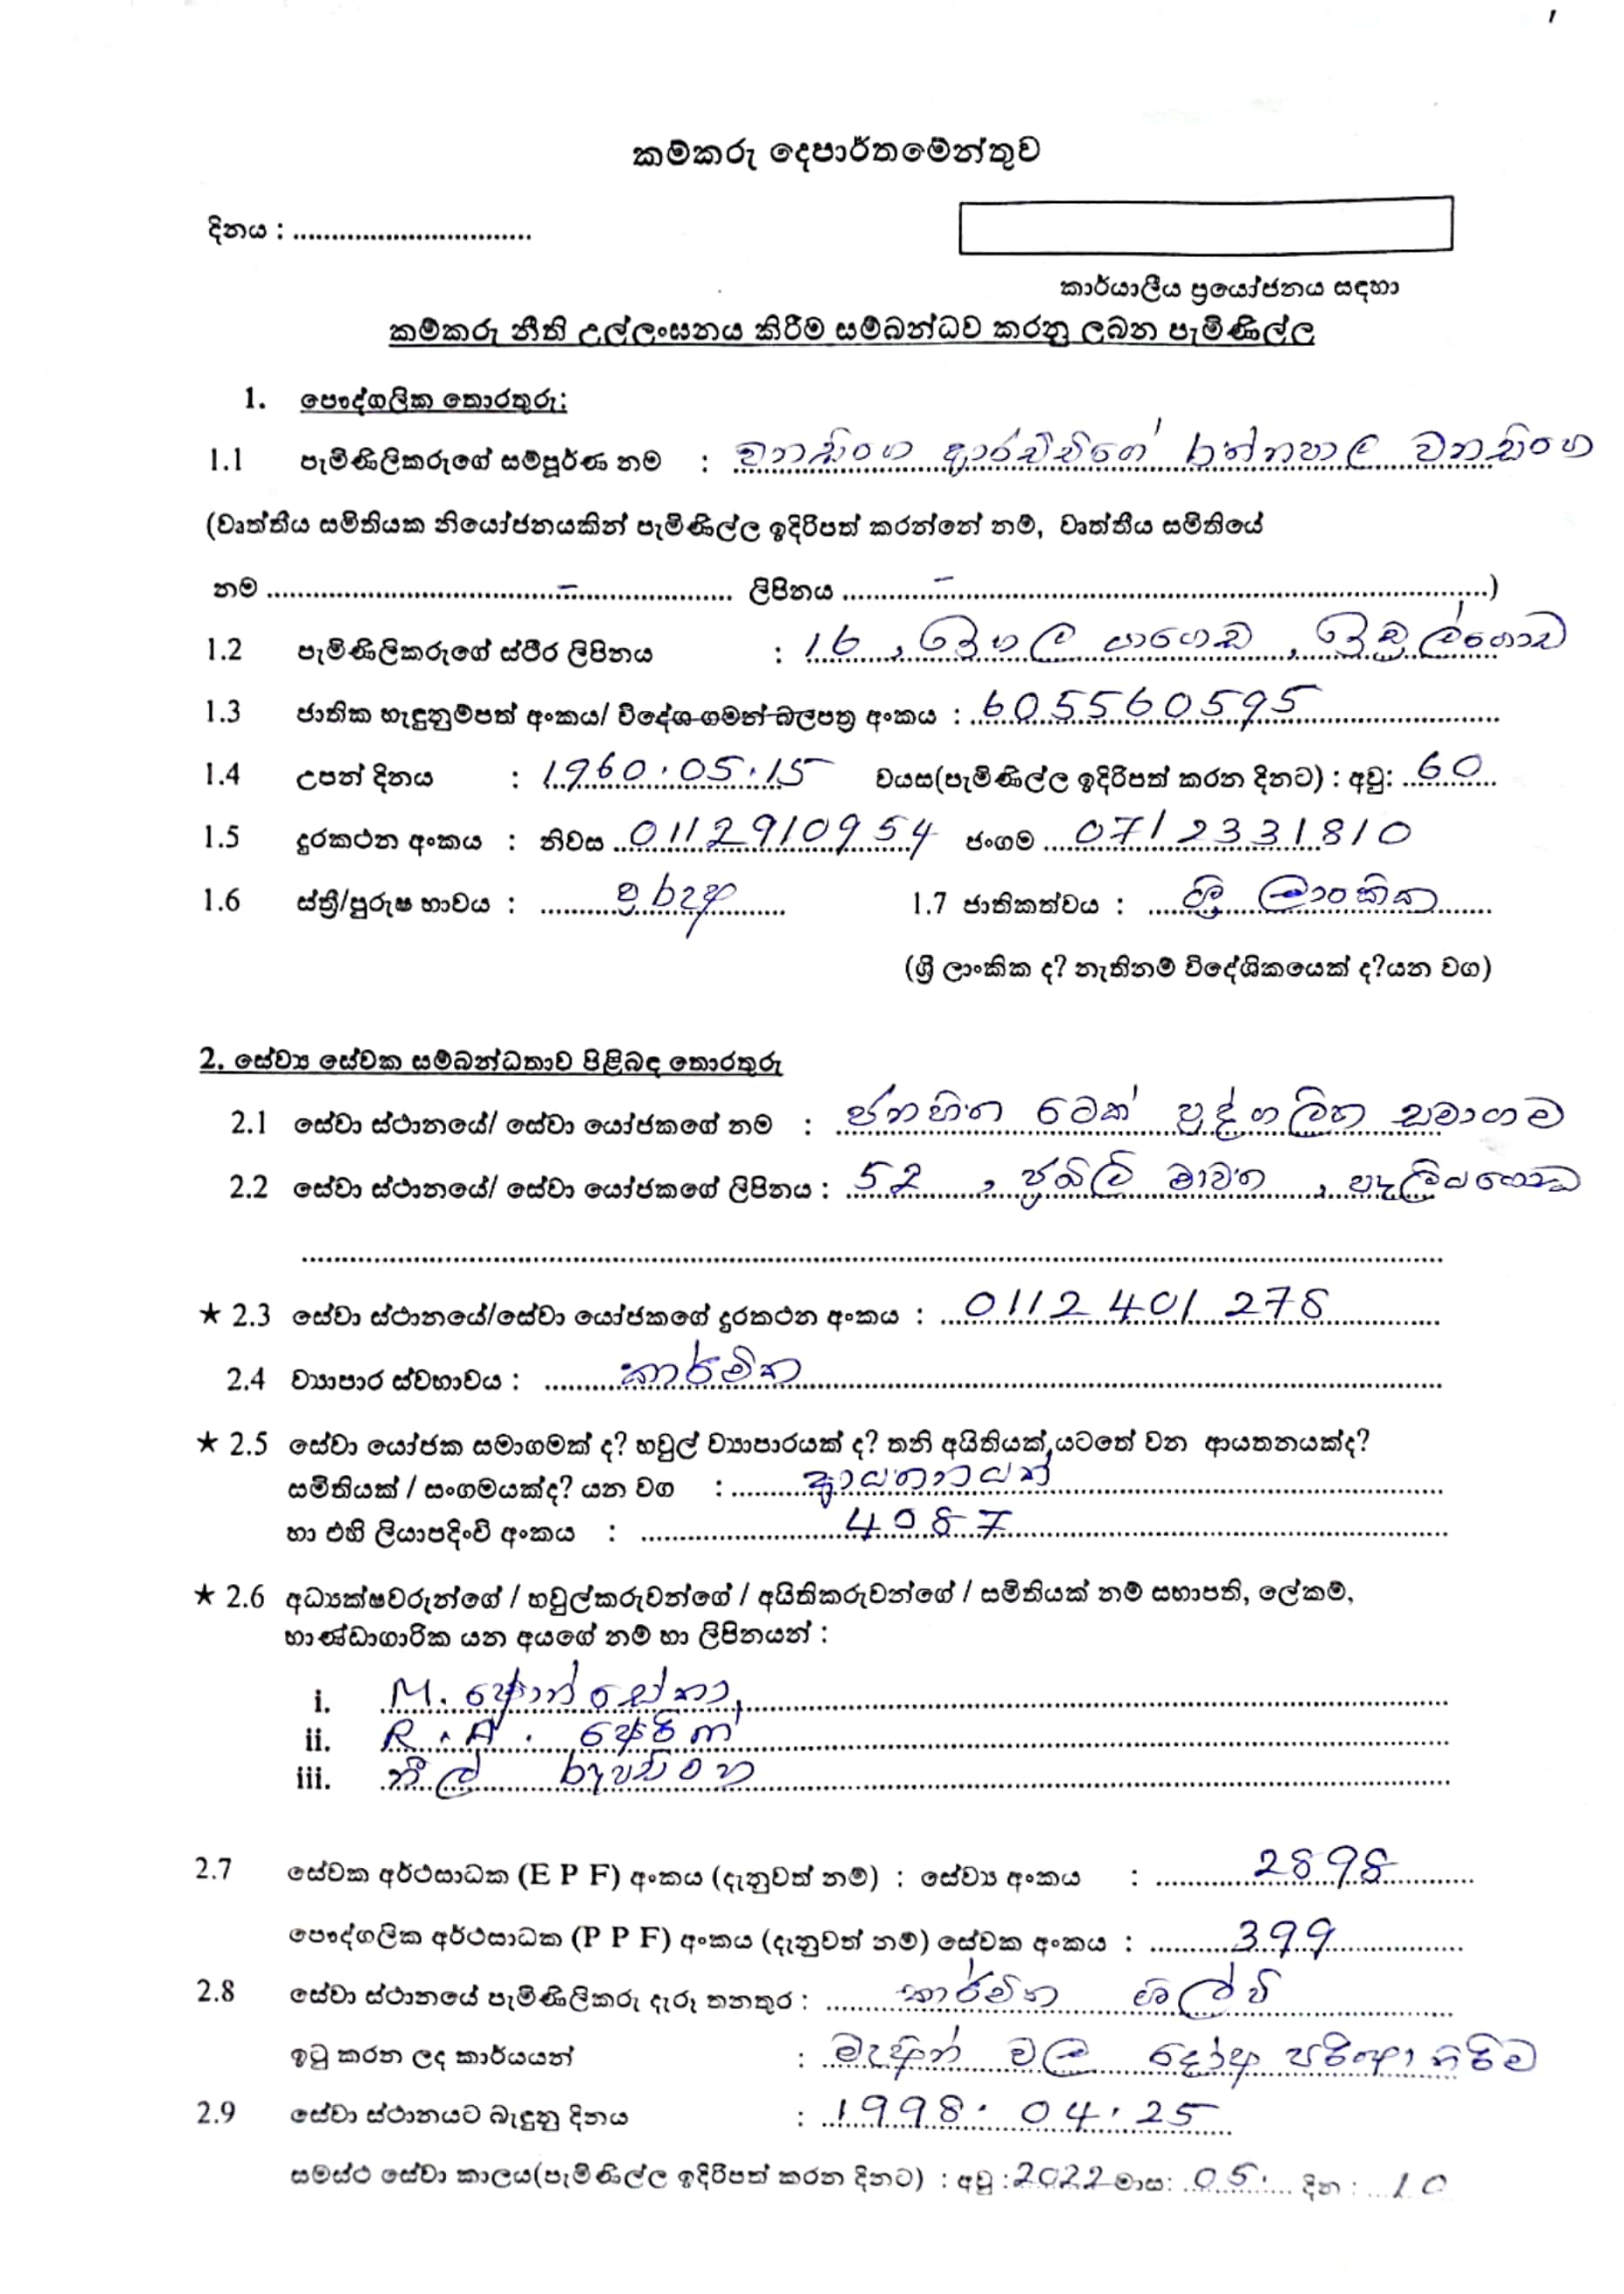

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

# Extracting handwritten text

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="Iur5I7kNoELBEDLFmusz")
project = rf.workspace().project("handwritten-text-detection-xbqh1")
model = project.version(2).model

# infer on a local image
output = model.predict(img_path, confidence=20, overlap=20).json()

# visualize your prediction
# model.predict("your_image.jpg", confidence=40, overlap=30).save("prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
bboxes = []
for prediction in output['predictions']:
  bboxes.append((prediction['x'] - prediction['width']//2, prediction['y'] - prediction['height']//2, prediction['width'], prediction['height'])) # x, y, w, h

In [ ]:
bboxes.sort(key=lambda x: x[1])

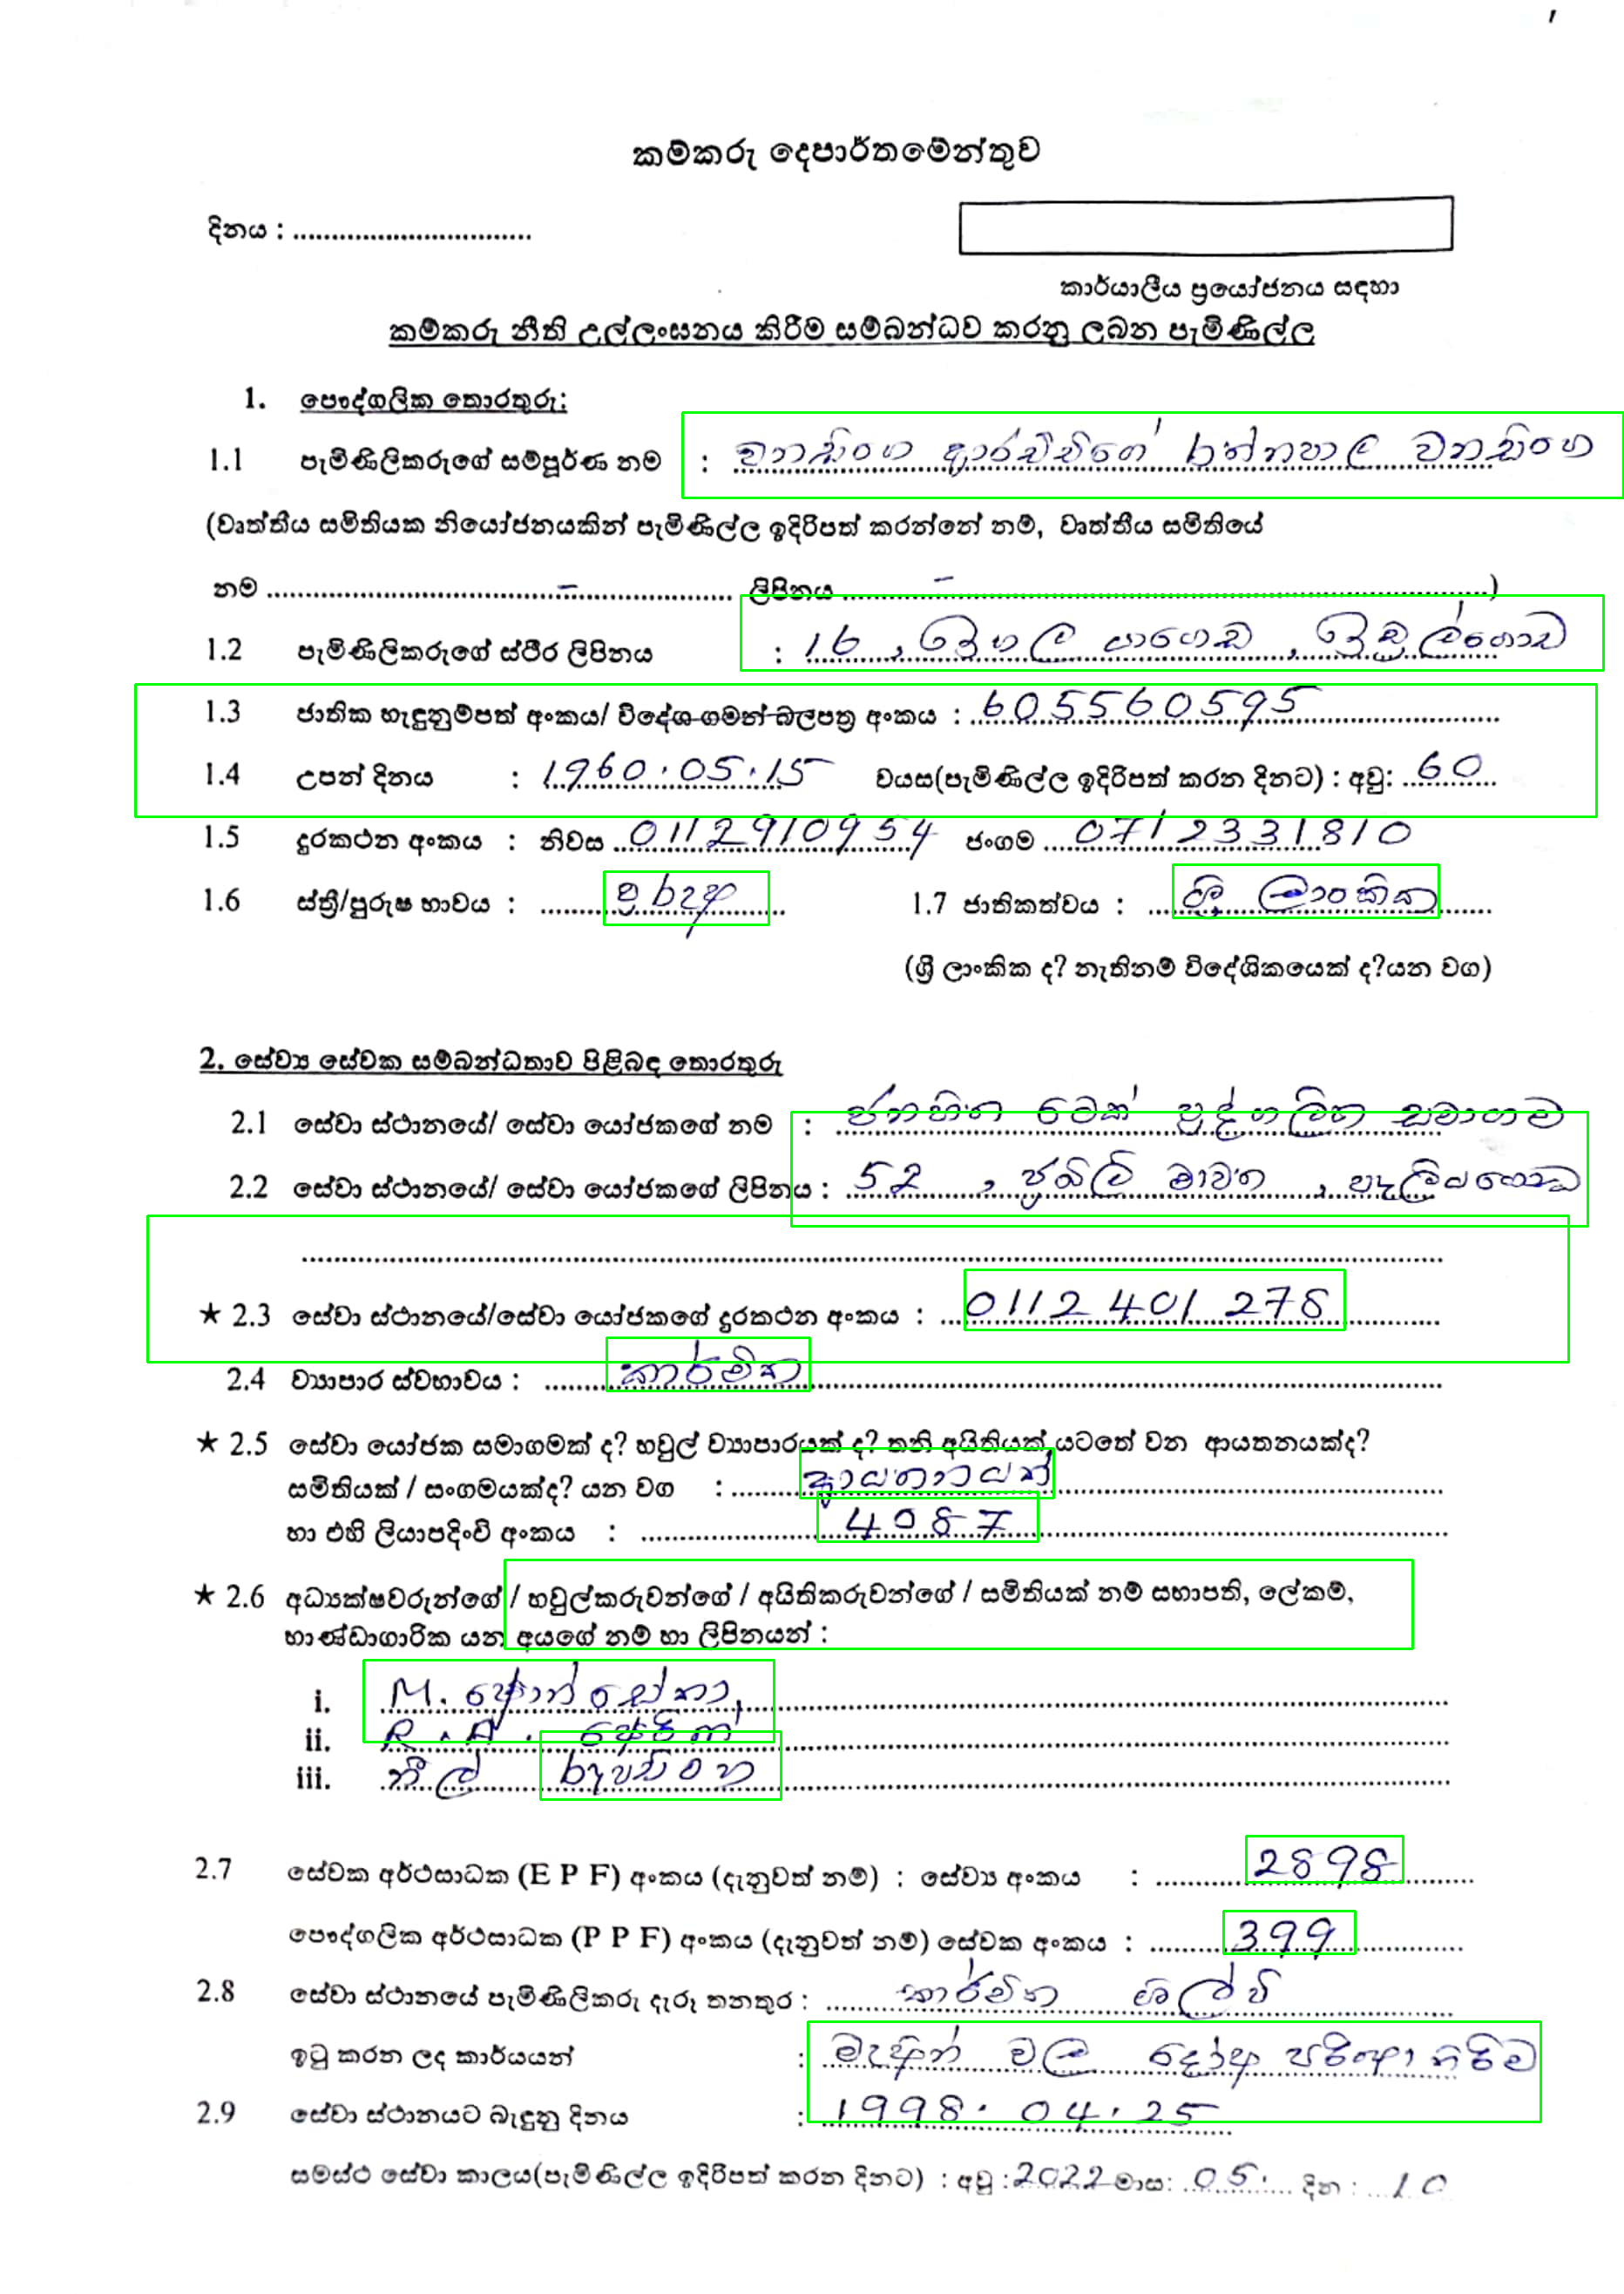

In [ ]:
handwritten_output = img.copy()
h, w, c = img.shape
for bbox in bboxes:
  start = (bbox[0], bbox[1])
  end = (bbox[0]+bbox[2], bbox[1]+bbox[3])
  handwritten_output = cv2.rectangle(handwritten_output, start, end, (0, 255, 0), 2)

cv2_imshow(handwritten_output)

In [ ]:
handwritten_pieces = []
for bbox in bboxes:
  crop_img = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
  temp = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
  thresh = cv2.adaptiveThreshold(temp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 5)
  handwritten_pieces.append(thresh)

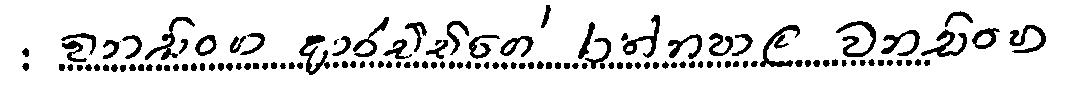

In [ ]:
cv2_imshow(handwritten_pieces[0])

# Methods

## Character bboxes

In [ ]:
def convert_grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

def blur(img, param):
  img = cv2.medianBlur(img, param)
  return img

def threshold(img):
  ret3, th3 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return ret3, th3

## pytesseract

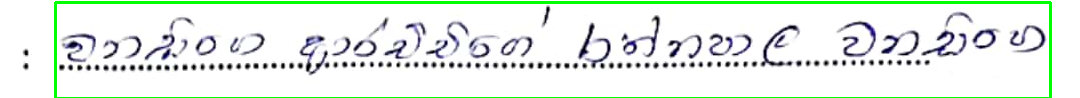

In [ ]:
input_img = handwritten_pieces[0].copy()
h, w, c = input_img.shape

boxes = pytesseract.image_to_boxes(input_img)

for b in boxes.splitlines():
  b = b.split(' ')
  input_img = cv2.rectangle(input_img, (int(b[1]), h-int(b[2])), (int(b[3]), h-int(b[4])), (0, 255, 0), 2)

cv2_imshow(input_img)

In [ ]:
boxes.splitlines()

['~ 55 0 1050 96 0']

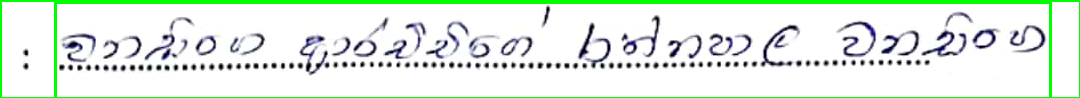

In [ ]:
input_img = handwritten_pieces[0].copy()
d = pytesseract.image_to_data(input_img, output_type=Output.DICT, lang='sin')
n_boxes = len(d['text'])
for i in range(n_boxes):
    (text,x,y,w,h) = (d['text'][i],d['left'][i],d['top'][i],d['width'][i],d['height'][i])
    cv2.rectangle(input_img, (x,y), (x+w,y+h) , (0,255,0), 2)
cv2_imshow(input_img)

In [ ]:
d

{'level': [1, 2, 3, 4, 5],
 'page_num': [1, 1, 1, 1, 1],
 'block_num': [0, 1, 1, 1, 1],
 'par_num': [0, 0, 1, 1, 1],
 'line_num': [0, 0, 0, 1, 1],
 'word_num': [0, 0, 0, 0, 1],
 'left': [0, 55, 55, 55, 55],
 'top': [0, 2, 2, 2, 2],
 'width': [1080, 995, 995, 995, 995],
 'height': [98, 96, 96, 96, 96],
 'conf': [-1, -1, -1, -1, 95],
 'text': ['', '', '', '', '']}

In [ ]:
input_img = handwritten_pieces[0].copy()
pytesseract.image_to_pdf_or_hocr(input_img, extension='hocr', config='-c hocr_char_boxes=1', lang='sin')

b'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"\n    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n <head>\n  <title></title>\n  <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>\n  <meta name=\'ocr-system\' content=\'tesseract 4.1.1\' />\n  <meta name=\'ocr-capabilities\' content=\'ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf\'/>\n </head>\n <body>\n  <div class=\'ocr_page\' id=\'page_1\' title=\'image "/tmp/tess_3b9r6sqy_input.PNG"; bbox 0 0 1080 98; ppageno 0\'>\n   <div class=\'ocr_carea\' id=\'block_1_1\' title="bbox 55 2 1050 98">\n    <p class=\'ocr_par\' id=\'par_1_1\' lang=\'sin\' title="bbox 55 2 1050 98">\n     <span class=\'ocr_line\' id=\'line_1_1\' title="bbox 55 2 1050 98; baseline 0 0; x_size 129.33333; x_descenders 32.333332; x_ascenders 32.333332">\n      <span class=\'ocrx_word\' id=\'word_1_1\' titl

## cv2 & np

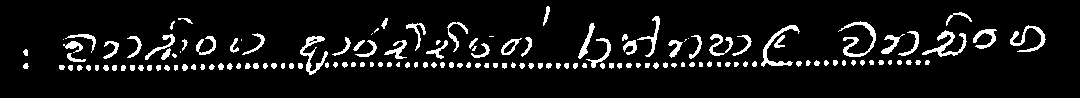

In [ ]:
input_img = handwritten_pieces[0].copy()

input_img = convert_grayscale(input_img)
ret3, th3 = threshold(input_img)
inverted = cv2.bitwise_not(th3)
cv2_imshow(inverted)

In [ ]:
result = inverted

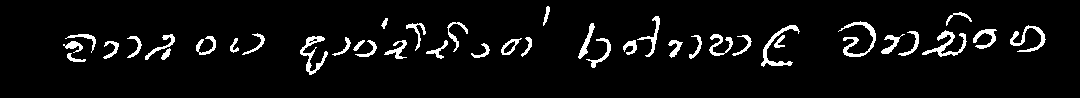

In [ ]:
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(inverted, None, None, None, 8, cv2.CV_32S)

#get CC_STAT_AREA component as stats[label, COLUMN]
areas = stats[1:,cv2.CC_STAT_AREA]

result = np.zeros((labels.shape), np.uint8)

for i in range(0, nlabels - 1):
    if areas[i] >= 40:   #keep
        result[labels == i + 1] = 255

cv2_imshow(result)

In [ ]:
vpp = np.sum(result, axis=0)

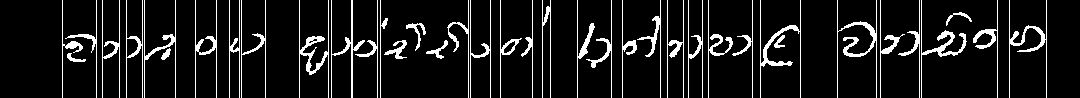

In [ ]:
vpp_output = result.copy()
chars = []
t = 0
h, w = result.shape
for i in range(len(vpp)-1):
  if vpp[i]<=t:
    if (vpp[i-1]>t and vpp[i+1]<=t) or (vpp[i-1]<=t and vpp[i+1]>t):
      vpp_output = cv2.line(vpp_output, (i, 0), (i, h), (255, 255, 255), 1)
cv2_imshow(vpp_output)

In [ ]:
chars = []
found_char = False
t = 0
h, w = result.shape
for i in range(len(vpp)-1):
  if vpp[i]<=t:
    if (vpp[i-1]<=t and vpp[i+1]>t):
      start = i
      found_char = True
    if (vpp[i-1]>t and vpp[i+1]<=t) and found_char:
      end = i
      chars.append((start, end))
      found_char = False

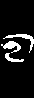

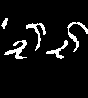

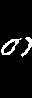

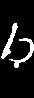

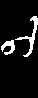

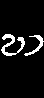

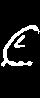

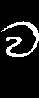

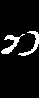

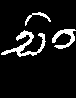

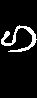

In [ ]:
for item in chars:
  char = result[:,item[0]:item[1]]
  cv2_imshow(char)

## cv2 contours

In [ ]:
input_img = handwritten_pieces[0].copy()

In [ ]:
input_img = cv2.fastNlMeansDenoisingColored(input_img,None,10,10,7,21)
gray = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)

res,thresh = cv2.threshold(gray,150,255,cv2.THRESH_BINARY_INV) #threshold
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))

dilated = cv2.dilate(thresh,kernel,iterations = 5)

contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

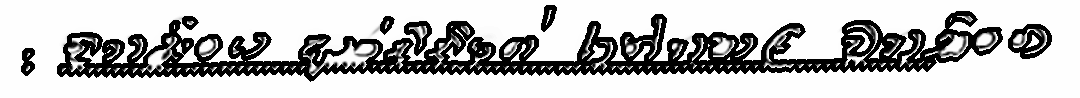

In [ ]:
temp = gray.copy()
cv2.drawContours(temp, contours, -1, (0, 255, 0), 3)
cv2_imshow(temp)

In [ ]:
len(contours)

23

In [ ]:
coord = []
for contour in contours:
  [x,y,w,h] = cv2.boundingRect(contour)
  if h>300 and w>300:
    continue
  if h<10 or w<10:
    continue
  coord.append((x,y,w,h))

In [ ]:
len(coord)

21

In [ ]:
coord.sort(key=lambda tup:tup[0]) # if the image has only one sentence sort in one axis

count = 0
for cor in coord:
  [x,y,w,h] = cor
  t = input_img[y:y+h,x:x+w,:]
  cv2.imwrite(str(count)+".png",t)
  count+=1
print("number of char in image:", count)

number of char in image: 21


In [ ]:
# !rm -rf /content/*.png

## https://github.com/RiteshKH/Cursive_handwriting_recognition

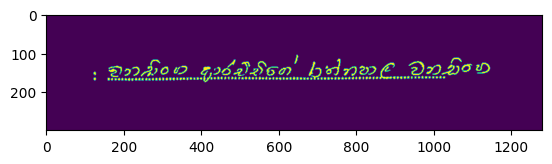

80.28 Angle (298, 1280)


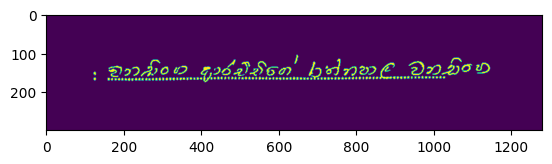

Ang -25
Ang -22
Ang -19
Ang -16
Ang -13
Ang -10
Ang -7
Ang -4
Ang -1
Ang 2
Ang 5
Ang 8
Ang 11
Ang 14
Ang 17
Ang 20
Ang 23


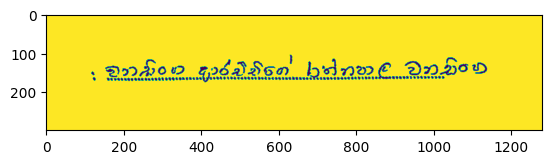

True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from collections import OrderedDict

# In[deskew]:
def deskew(img):
    thresh=img
    edges = cv2.Canny(thresh,50,200,apertureSize = 3)

    lines = cv2.HoughLines(edges,1,np.pi/1000, 55)
    try:
        d1 = OrderedDict()
        for i in range(len(lines)):
            for rho,theta in lines[i]:
                deg = np.rad2deg(theta)
#                print(deg)
                if deg in d1:
                    d1[deg] += 1
                else:
                    d1[deg] = 1

        t1 = OrderedDict(sorted(d1.items(), key=lambda x:x[1] , reverse=False))
        print(list(t1.keys())[0],'Angle' ,thresh.shape)
        non_zero_pixels = cv2.findNonZero(thresh)
        center, wh, theta = cv2.minAreaRect(non_zero_pixels)
        angle=list(t1.keys())[0]
        if angle>160:
            angle=180-angle
        if angle<160 and angle>20:
            angle=12
        root_mat = cv2.getRotationMatrix2D(center, angle, 1)
        rows, cols = img.shape
        rotated = cv2.warpAffine(img, root_mat, (cols, rows), flags=cv2.INTER_CUBIC)

    except:
        rotated=img
        pass
    return rotated

def unshear(img):

    gray = img
    thresh = img.copy()
    #print(thresh)
    plt.imshow(thresh)
    plt.show()
    trans = thresh.transpose()

    arr=[]
    for i in range(thresh.shape[1]):
        arr.insert(0,trans[i].sum())

    arr=[]
    for i in range(thresh.shape[0]):
        arr.insert(0,thresh[i].sum())

    y = thresh.shape[0]-1-np.nonzero(arr)[0][0]
    y_top = thresh.shape[0]-1-np.nonzero(arr)[0][-1]

    trans1 = thresh.transpose()
    sum1=[]
    for i in range(trans1.shape[0]):
        sum1.insert(i,trans1[i].sum())

    height = y - y_top
    max_value = 255*height
    prev_num = len([i for i in sum1 if i>=(0.6*max_value)])
    final_ang = 0

    # # print(arr)
    # # print(x,y)
    for ang in range(-25,25,3):
        thresh = gray.copy()
        #print(thresh[0].shape)
        #print(ang)
        print('Ang',ang)
        if ang>0:
            #print(ang)
            for i in range(y):
                temp = thresh[i]
                move = int((y-i)*(math.tan(math.radians(ang))))
                if move >= temp.size:
                    move = temp.size
                thresh[i][:temp.size-move]=temp[move:]
                thresh[i][temp.size-move:] = [0 for m in range(move)]
        else:
            #print(ang)
            for i in range(y):
                temp = thresh[i]
                move = int((y-i)*(math.tan(math.radians(-ang))))
                if move >= temp.size:
                    move = temp.size
                #print(temp[:-3])
                #print(temp[:temp.size-move].shape, thresh[i][move%temp.size:].shape)
                thresh[i][move:]=temp[:temp.size-move]
                thresh[i][:move]=[0 for m in range(move)]

#         plt.imshow(thresh)
#         plt.show()
        trans1 = thresh.transpose()
        sum1=[]
        for i in range(trans1.shape[0]):
            sum1.insert(i,trans1[i].sum())
        #print(sum1)
        num = len([i for i in sum1 if i>=(0.60*max_value)])
        #print(num, prev_num)
        if(num>=prev_num):
            prev_num=num
            final_ang = ang
        #plt.imshow(thresh)
        #plt.show()
    #print("final_ang:", final_ang)

    thresh= gray.copy()
    if final_ang>0:
        for i in range(y):
            temp = thresh[i]
            move = int((y-i)*(math.tan(math.radians(final_ang))))
            if move >= temp.size:
                move = temp.size
            thresh[i][:temp.size-move]=temp[move:]
            thresh[i][temp.size-move:] = [0 for m in range(move)]
    else:
        for i in range(y):
            temp = thresh[i]
            move = int((y-i)*(math.tan(math.radians(-final_ang))))
            #print(move)
            if move >= temp.size:
                move = temp.size
            thresh[i][move:]=temp[:temp.size-move]
            thresh[i][:move]=[0 for m in range(move)]

#    plt.imshow(thresh)
#    plt.show()
    return thresh


# In[Main]:

def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 40)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value
     return vector

input_img = handwritten_pieces[0].copy()

# input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

thresh = cv2.threshold(input_img,127,255,1)[1]
thresh=np.pad(thresh, 100, pad_with, padder=0)

plt.imshow(thresh)
plt.show()
deskew(thresh)
sheared_img = unshear(thresh)

ret, thresh = cv2.threshold(sheared_img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(thresh)
plt.show()
cv2.imwrite('thresh.png', thresh)

No. of Lines 1


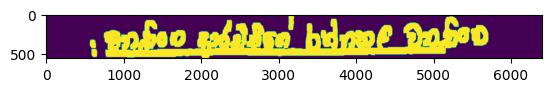

Area=  1296525.0
745 28 4725 532
Area=  37881.0
1595 204 210 216
Area=  13643.0
3125 0 75 204
Area=  49454.5
5480 140 230 264
No. of Words 4
LetterGray shape:  (560, 4725, 3)
Upper:: Max, min, avg, mean::  494 0 247 262
Lower:: Max, min, avg, mean::  560 146 353 493
Max pixels at:  486


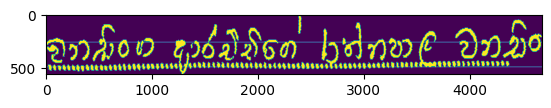

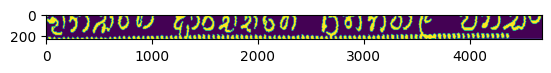

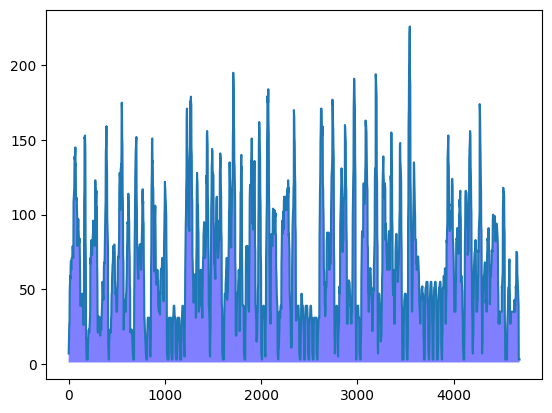

At arr Seg here:  [4, 218, 339, 439, 573, 679, 854, 1206, 1473, 1614, 1778, 1835, 1959, 2045, 2189, 2319, 2593, 2804, 3038, 3156, 3249, 3524, 3884, 4111, 4204, 4299, 4555]
Difference array:  [29, 185, 231, 90, 231, 185, 193, 151, 177, 48, 231, 36, 37, 196, 230, 230, 33, 29, 209, 231, 102, 176, 55, 219, 88, 48, 34]
Does it work::::


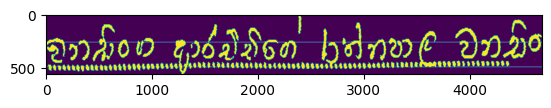

Does it work::::


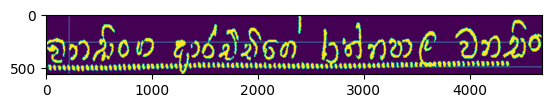

Does it work::::


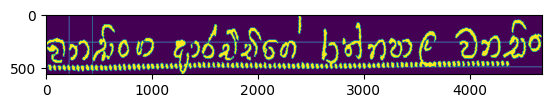

Does it work::::


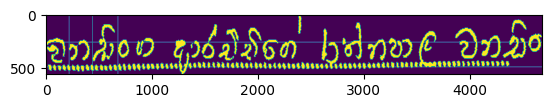

Does it work::::


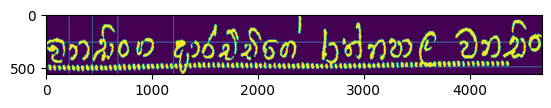

Does it work::::


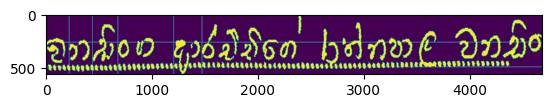

Does it work::::


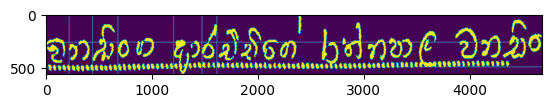

Does it work::::


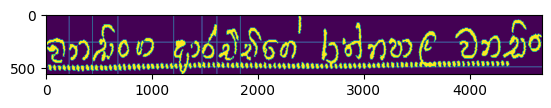

Does it work::::


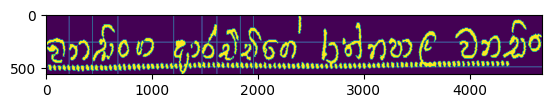

Does it work::::


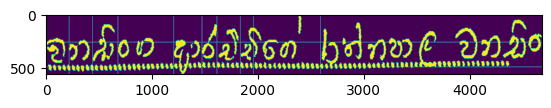

Does it work::::


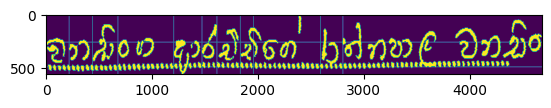

Does it work::::


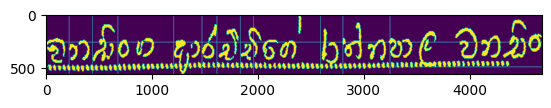

Does it work::::


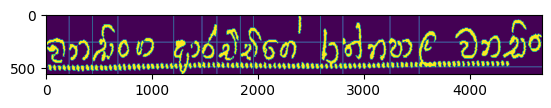

Does it work::::


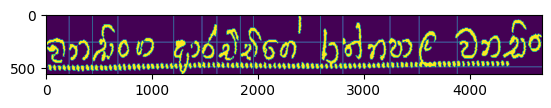

Does it work::::


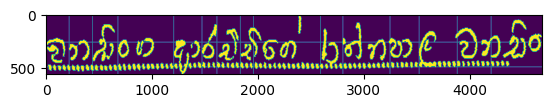

Does it work::::


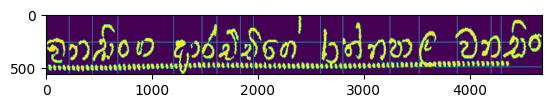

Does it work::::


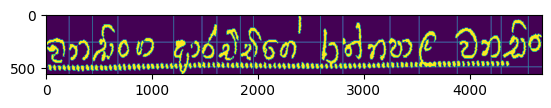

count 33142


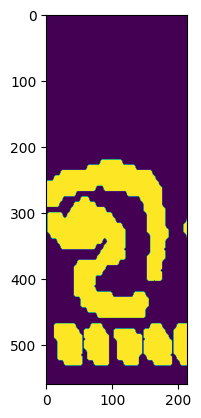

count 29888


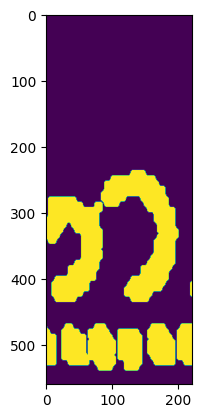

count 41190


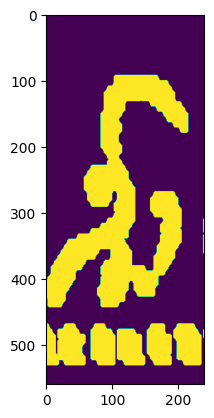

count 57055


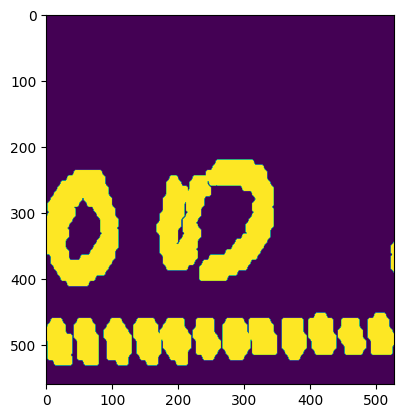

count 41034


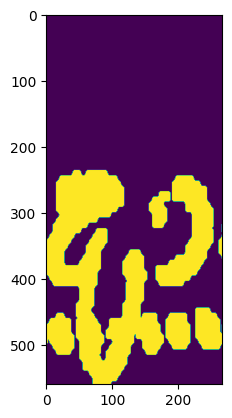

count 24487


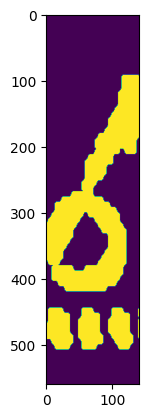

count 35508


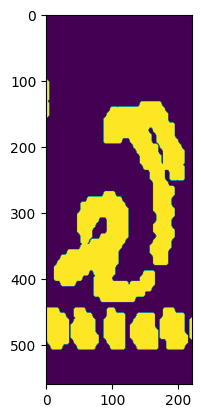

count 21035


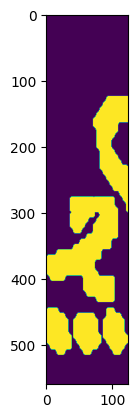

count 78456


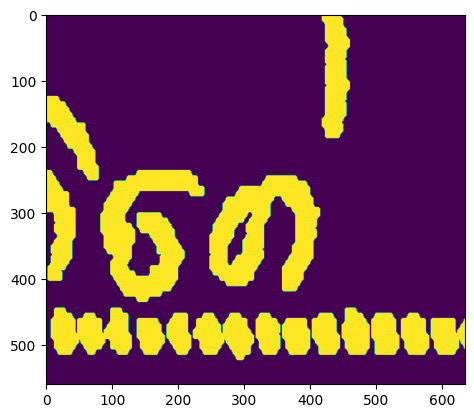

count 32104


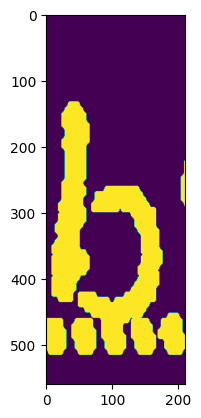

count 64912


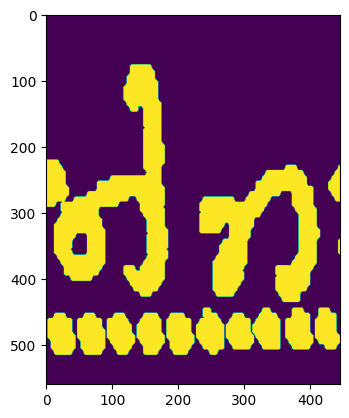

count 35954


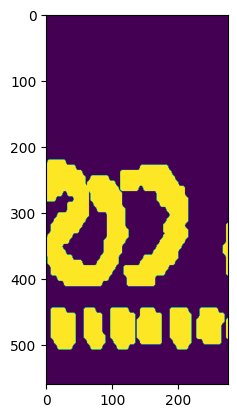

count 38997


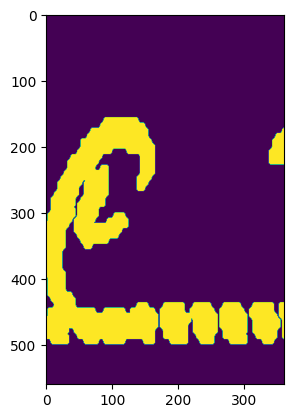

count 50541


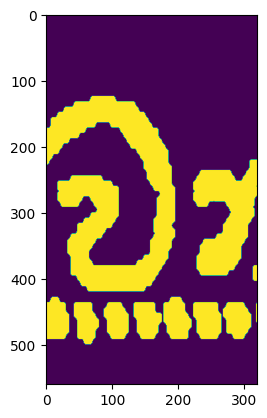

count 14245


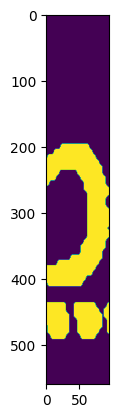

count 14389


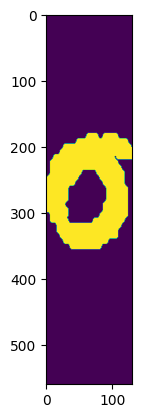

LetterGray shape:  (560, 210, 3)
Upper:: Max, min, avg, mean::  257 0 128 37
Lower:: Max, min, avg, mean::  304 156 230 292
Max pixels at:  209


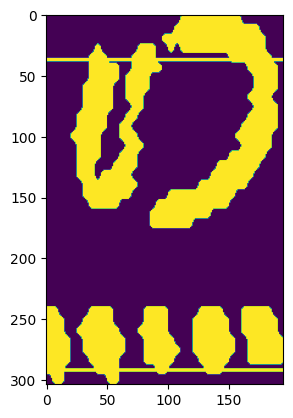

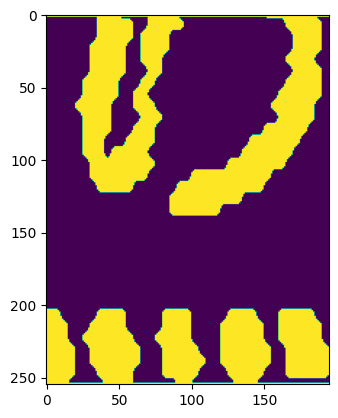

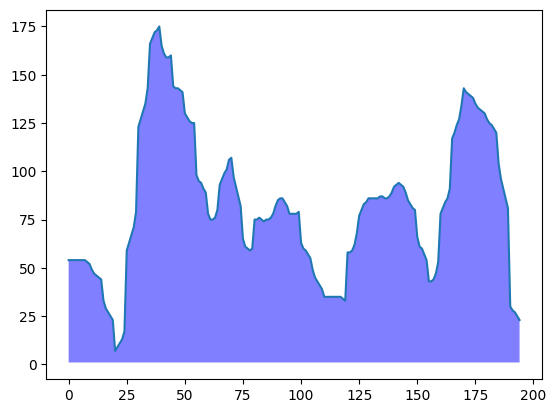

At arr Seg here:  [24]
Difference array:  [193]
LetterGray shape:  (560, 75, 3)
Upper:: Max, min, avg, mean::  452 0 226 166
Lower:: Max, min, avg, mean::  512 181 346 497
Max pixels at:  284


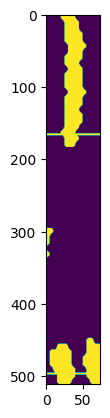

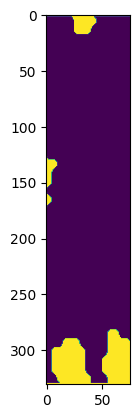

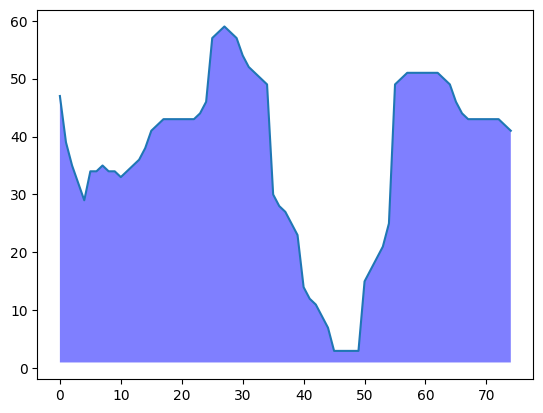

At arr Seg here:  []
Difference array:  []
LetterGray shape:  (560, 230, 3)
Upper:: Max, min, avg, mean::  140 0 70 27
Lower:: Max, min, avg, mean::  224 76 150 205
Max pixels at:  206


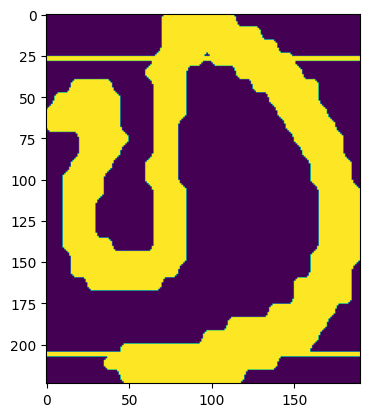

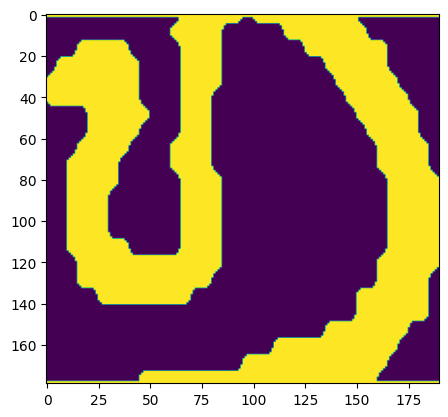

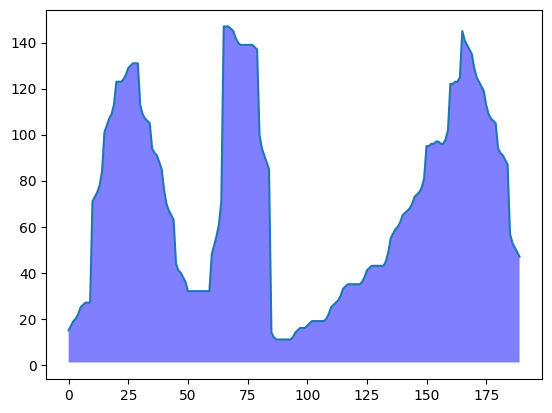

At arr Seg here:  [4]
Difference array:  [31]
Does it work::::


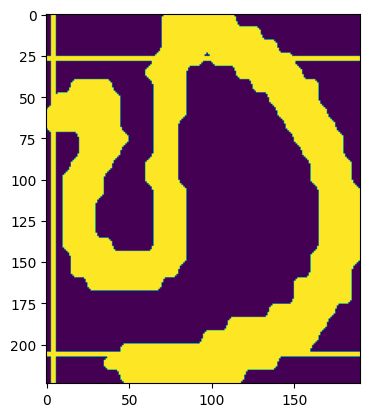

Original Image


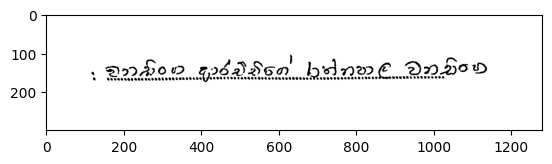

NoneType: None


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mpl
import traceback
import os

mpl.rcParams['legend.fontsize'] = 10

pd.set_option('display.expand_frame_repr', False)
fn=0
path='./result/'

# In[findFeaturPoints]
def findCapPoints(img):
    cpoints=[]
    dpoints=[]
    for i in range(img.shape[1]):
        col = img[:,i:i+1]
        k = col.shape[0]
        while k > 0:
            if col[k-1]==255:
                dpoints.append((i,k))
                break
            k-=1

        for j in range(col.shape[0]):
            if col[j]==255:
                cpoints.append((i,j))
                break
    return cpoints,dpoints


# In[wordSegment]
#*****************************************************************************#
def wordSegment(textLines):
    wordImgList=[]
    counter=0
    cl=0
    for txtLine in textLines:
        gray = cv.cvtColor(txtLine, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 100, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
        final_thr = cv.dilate(threshed,None,iterations = 20)

        plt.imshow(final_thr)
        plt.show()

        contours, hierarchy = cv.findContours(final_thr,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
        boundingBoxes = [cv.boundingRect(c) for c in contours]
        (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: b[1][0], reverse=False))

        for cnt in contours:
            area = cv.contourArea(cnt)

#            print area
            if area > 10000:
                print ('Area= ',area)
                x,y,w,h = cv.boundingRect(cnt)
                print (x,y,w,h)
                letterBgr = txtLine[0:txtLine.shape[1],x:x+w]
                wordImgList.append(letterBgr)

                cv.imwrite("./result/words/" + str(counter) +".jpg",letterBgr)
                counter=counter+1
        cl=cl+1

    return wordImgList
#*****************************************************************************#

# In[fitToSize]
#*****************************************************************************#
def fitToSize(thresh1):

    mask = thresh1 > 0
    coords = np.argwhere(mask)

    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    cropped = thresh1[x0:x1,y0:y1]
    return cropped

#*****************************************************************************#

# In[lineSegment]
#*****************************************************************************#
def lineSegment(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)

    upper=[]
    lower=[]
    flag=True
    for i in range(threshed.shape[0]):

        col = threshed[i:i+1,:]
        cnt=0
        if flag:
            cnt=np.count_nonzero(col == 255)
            if cnt >0:
                upper.append(i)
                flag=False
        else:
            cnt=np.count_nonzero(col == 255)
            if cnt <2:
                lower.append(i)
                flag=True
    textLines=[]
    if len(upper)!= len(lower):lower.append(threshed.shape[0])
#    print upper
#    print lower
    for i in range(len(upper)):
        timg=img[upper[i]:lower[i],0:]

        if timg.shape[0]>5:
#            plt.imshow(timg)
#            plt.show()
            timg=cv.resize(timg,((timg.shape[1]*5,timg.shape[0]*8)))
            textLines.append(timg)

    return textLines
#*****************************************************************************#

# In[baselines]:
##******************************************************************************#
def baselines(letter2, upoints, dpoints):
##-------------------------Creating upper baseline-------------------------------##
    colu = []
    for i in range(len(upoints)):
        colu.append(upoints[i][1])

    maxyu = max(colu)
    minyu = min(colu)
    avgu = (maxyu + minyu) // 2
    meanu = np.around(np.mean(colu)).astype(int)
    print('Upper:: Max, min, avg, mean:: ',maxyu, minyu, avgu, meanu)

##-------------------------------------------------------------------------------##
##-------------------------Creating lower baseline process 1--------------------------##
    cold = []
    for i in range(len(dpoints)):
        cold.append(dpoints[i][1])

    maxyd = max(cold)
    minyd = min(cold)
    avgd = (maxyd + minyd) // 2
    meand = np.around(np.mean(cold)).astype(int)
    print('Lower:: Max, min, avg, mean:: ',maxyd, minyd, avgd, meand)

##-------------------------------------------------------------------------------##
##-------------------------Creating lower baseline process 2---------------------------##
    cn = []
    count = 0

    for i in range(h):
        for j in range(w):
            if(letterGray[i,j] == 255):
                count+=1
        if(count != 0):
            cn.append(count)
            count = 0
    maxindex = cn.index(max(cn))
    print('Max pixels at: ',maxindex)

##------------------Printing upper and lower baselines-----------------------------##

    cv.line(letter2,(0,meanu),(w,meanu),(255,0,0),2)
    lb = 0
    if(maxindex > meand):
        lb = maxindex
        cv.line(letter2,(0,maxindex),(w,maxindex),(255,0,0),2)
    else:
        lb = meand
        cv.line(letter2,(0,meand),(w,meand),(255,0,0),2)

    plt.imshow(letter2)
    plt.show()
    return meanu, lb
##******************************************************************************###

# In[histogram]:
##*******************************************************************************###
def histogram(letter2, upper_baseline, lower_baseline):
    ##------------Making Histograms (Default)------------------------######
    cropped = letter2[upper_baseline:lower_baseline,0:w]
    plt.imshow(cropped)
    plt.show()
    colcnt = np.sum(cropped==255, axis=0)
    x = list(range(len(colcnt)))
    plt.plot(colcnt)
    plt.fill_between(x, colcnt, 1, facecolor='blue', alpha=0.5)
    plt.show()
    return colcnt
####---------------------------------------------------------------------------#####

# In[Visualize]:
##*******************************************************************************###
def visualize(letter2, upper_baseline, lower_baseline, min_pixel_threshold, min_separation_threshold, min_round_letter_threshold):
    seg = []
    seg1 = []
    seg2 = []
   ## Check if pixel count is less than min_pixel_threshold, add segmentation point
    for i in range(len(colcnt)):
      if(colcnt[i] < min_pixel_threshold):
          seg1.append(i)

    ## Check if 2 consequtive seg points are greater than min_separation_threshold in distance
    for i in range(len(seg1)-1):
        if(seg1[i+1]-seg1[i] > min_separation_threshold):
            seg2.append(seg1[i])

##------------Modified segmentation for removing circles----------------------------###
    arr=[]
    for i in (seg2):
        arr1 = []
        j = upper_baseline
        while(j <= lower_baseline):
            if(letterGray[j,i] == 255):
                arr1.append(1)
            else:
                arr1.append(0)
            j+=1
        arr.append(arr1)
    print('At arr Seg here: ', seg2)

    ones = []
    for i in (arr):
        ones1 = []
        for j in range(len(i)):
            if (i[j] == 1):
                ones1.append([j])
        ones.append(ones1)

    diffarr = []
    for i in (ones):
        diff = i[len(i)-1][0] - i[0][0]
        diffarr.append(diff)
    print('Difference array: ',diffarr)

    for i in range(len(seg2)):
        if(diffarr[i] < min_round_letter_threshold):
            seg.append(seg2[i])
##---------------------------------------------------------------------------##
    ## Make the Cut
    for i in range(len(seg)):
        letter3 = cv.line(letter2,(seg[i],0),(seg[i],h),(255,0,0),2)

        print("Does it work::::")
        plt.imshow(letter3)
        plt.show()
    return seg
###---------------------------------------------------------------------------#####

# In[segmentCharacters]
def segmentCharacters(seg,lettergray):
    s=0
    wordImgList = []
    global fn
    for i in range(len(seg)):
        if i==0:
            s=seg[i]
            if s > 15:
                wordImg = lettergray[0:,0:s]
                cntx=np.count_nonzero(wordImg == 255)
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
            else:
                continue
        elif (i != (len(seg)-1)):
            if seg[i]-s > 15:
                wordImg = lettergray[0:,s:seg[i]]
                cntx=np.count_nonzero(wordImg == 255)
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
                s=seg[i]
            else:
                continue
        else:
            wordImg = lettergray[0:,seg[len(seg)-1]:]
            cntx=np.count_nonzero(wordImg == 255)
            print ('count',cntx)
            plt.imshow(wordImg)
            plt.show()
            fn=fn+1
        wordImgList.append(wordImg)

    return wordImgList

#*****************************************************************************#
# In[Main]:
try:
  os.mkdir('/content/result')
  os.mkdir('/content/result/characters/')
except:
  pass

try:
    thresh = cv.imread('/content/thresh.png')
    textLines=lineSegment(thresh)
    print ('No. of Lines',len(textLines))
    imgList=wordSegment(textLines)
    print ('No. of Words',len(imgList))
    counter = 0
    for letterGray in imgList:
        print ('LetterGray shape: ',letterGray.shape)
        gray = cv.cvtColor(letterGray, cv.COLOR_BGR2GRAY)
        th, letterGray = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
        letterGray = fitToSize(letterGray)
        letter2 = letterGray.copy()
        letterGray = cv.dilate(letterGray,None,iterations = 4)
        h = letterGray.shape[0]
        w = letterGray.shape[1]

        upoints, dpoints=findCapPoints(letterGray)
        meanu, lb = baselines(letter2, upoints, dpoints)

##-----------Final Baseline row numbers-----------------------####
#       Ignore all points avove and below these rows
        upper_baseline = meanu
        lower_baseline = lb

##--------------------Make histogram-------------------------------------###

        colcnt = histogram(letter2, upper_baseline, lower_baseline)

###------------------------Visualize segmentation------------------------------#####
        ## Tuning Parameters
        min_pixel_threshold = 25
        min_separation_threshold = 35
        min_round_letter_threshold = 190

        seg = visualize(letter2, upper_baseline, lower_baseline, min_pixel_threshold, min_separation_threshold, min_round_letter_threshold)
        wordImgList = segmentCharacters(seg,letterGray)
        for i in wordImgList:
            cv.imwrite("/content/result/characters/" + str(counter) +".jpeg",i)
            counter=counter+1

###---------------------------------------------------------------------------#####

    print('Original Image')
    plt.imshow(thresh)
    plt.show()

except Exception as e:
    print ('Error Message ',e)
    traceback.print_exc()
    pass

traceback.print_exc()



In [ ]:
import numpy as np
import cv2
import os


def add_padding(img, pad_l, pad_t, pad_r, pad_b):

    height, width = img.shape
    #Adding padding to the left side.
    pad_left = np.zeros((height, pad_l), dtype = np.int)
    img = np.concatenate((pad_left, img), axis = 1)

    #Adding padding to the top.
    pad_up = np.zeros((pad_t, pad_l + width))
    img = np.concatenate((pad_up, img), axis = 0)

    #Adding padding to the right.
    pad_right = np.zeros((height + pad_t, pad_r))
    img = np.concatenate((img, pad_right), axis = 1)

    #Adding padding to the bottom
    pad_bottom = np.zeros((pad_b, pad_l + width + pad_r))
    img = np.concatenate((img, pad_bottom), axis = 0)

    return img

try:
  os.mkdir('/content/result/resized_images/')
except:
  pass

images = []
folder='/content/result/characters/'
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    th, a = cv2.threshold(img, 127, 255,cv2.THRESH_OTSU)
    if a is not None:
        a=cv2.resize(a,(100,80))
        # create blank image - y, x
        col_sum = np.where(np.sum(a, axis = 0)>0)
        row_sum = np.where(np.sum(a, axis = 1)>0)
        y1, y2 = row_sum[0][0], row_sum[0][-1]
        x1, x2 = col_sum[0][0], col_sum[0][-1]

        cropped_image = a[y1:y2, x1:x2]
        cropped_image=cv2.resize(cropped_image,(20,20))
        padded_image = add_padding(cropped_image, 4, 4, 4, 4)
        cv2.imwrite('/content/result/resized_images/'+filename,padded_image)
        cv2_imshow(padded_image)
        print()

print("Images resized and saved into designated folder")

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Images resized and saved into designated folder
